<a href="https://colab.research.google.com/github/iamatul1214/Tensorflow_Certification_Preparation/blob/main/06_Transfer_learning_using_tensorflow_part3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Till now we saw that feature extraction and Fine tuning transfer learning has worked nicely, now we will try to implement same on food101 dataset of 10% training data with 101 food classes.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
Root = "/content/drive/MyDrive/Tensorflow certifications work"
!pwd
os.chdir(Root)
!pwd

/content/drive/MyDrive/Tensorflow certifications work
/content/drive/MyDrive/Tensorflow certifications work


## installing the helper functions file

In [7]:
try:
  if os.path.exists("Helper.py"):
    print("Helper file already exists..skipping download")
  else:
    !wget https://raw.githubusercontent.com/iamatul1214/Tensorflow_Certification_Preparation/main/Helper.py
    print("downloaded Helper.py")
except Exception as e:
  print(e)

--2022-12-13 07:08:48--  https://raw.githubusercontent.com/iamatul1214/Tensorflow_Certification_Preparation/main/Helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11944 (12K) [text/plain]
Saving to: ‘Helper.py’

Helper.py           100%[===================>]  11.66K  --.-KB/s    in 0.001s  

2022-12-13 07:08:48 (9.76 MB/s) - ‘Helper.py’ saved [11944/11944]

downloaded Helper.py


In [8]:
## Downloading the dataset
from Helper import unzip_data
try:
  if os.path.exists("101_food_classes_10_percent"):
    print("data already exists...hence, skipping downloading....")
  else:
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
    unzip_data("101_food_classes_10_percent.zip")
    print("unzipping the data")
except Exception as e:
  print(e)


--2022-12-13 07:08:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  38.3MB/s    in 42s     

2022-12-13 07:09:39 (36.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

unzipping the data


In [9]:
## Setting up the data loaders
import tensorflow as tf
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"
IMG_SIZE = (224,224)

full_classes_10_percent_train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                         label_mode = 'categorical',
                                                                                         image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## train a big dog model with transfer learning on 10% of the 101 food classes

Here are the steps we will follow-
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build a data augmentation right into the moddel
* BUild a headless(no top layers) functional EfficientNetB0 backboned-model ( we will create our own output layer) 
* compile our model
* feature extract for 5 full passes( 5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [10]:
## creating a checkpoint callback
from Helper import create_tensorboard_callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True,
                                                         save_weights_only = True)


In [11]:
## Data augmentation layer to incorporate right into the model
from tensorflow.keras.layers.experimental import preprocessing

## setup data augmentation
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.). ## not required for efficientNetB0 but for resnet50
], name = "Data_augmentataiton_layer")


In [12]:
## Setup the base model and freeze its layers ( this will extract the features )
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

## Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs) #augment images( only happens during training phase)
x = base_model(x, training = False) # put the base model in inference mode so weights which need to stay frozen will remian frozen
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x)
outputs = tf.keras.layers.Dense(len(full_classes_10_percent_train_data.class_names), activation="softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs,outputs)


16705208/16705208 [==============================] - 1s 0us/step


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_augmentataiton_layer (  (None, 224, 224, 3)      0         
 Sequential)                                                     
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [14]:
## compiling the model
model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [15]:
## Training the model for 5 epochs
history_all_classes_10_percent = model.fit(full_classes_10_percent_train_data,epochs = 5, 
         steps_per_epoch = len(full_classes_10_percent_train_data),
          validation_data = test_data,
          validation_steps = int(0.5 * len(test_data)),
          callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 132s 497ms/step - loss: 3.3531 - accuracy: 0.2751 - val_loss: 2.3501 - val_accuracy: 0.4805
Epoch 2/5
237/237 [==============================] - 98s 410ms/step - loss: 2.1913 - accuracy: 0.5015 - val_loss: 1.9315 - val_accuracy: 0.5306
Epoch 3/5
237/237 [==============================] - 95s 398ms/step - loss: 1.8224 - accuracy: 0.5659 - val_loss: 1.7646 - val_accuracy: 0.5537
Epoch 4/5
237/237 [==============================] - 87s 364ms/step - loss: 1.6040 - accuracy: 0.6132 - val_loss: 1.6852 - val_accuracy: 0.5684
Epoch 5/5
237/237 [==============================] - 85s 355ms/step - loss: 1.4367 - accuracy: 0.6483 - val_loss: 1.6495 - val_accuracy: 0.5716


In [16]:
## Evaluate on whole test dataset
model.evaluate(test_data)

790/790 [==============================] - 84s 106ms/step - loss: 1.5719 - accuracy: 0.5908


[1.571937918663025, 0.5908119082450867]

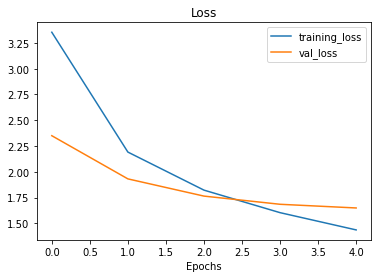

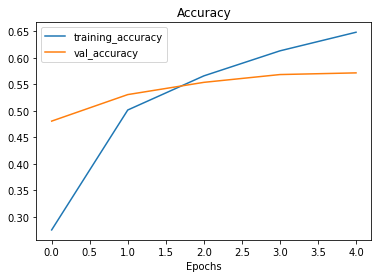

In [17]:
from Helper import plot_loss_curves
plot_loss_curves(history_all_classes_10_percent)

## Fine Tuning

In [18]:
## Unfreeze all the layers in the base model
base_model.trainable = True

## Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = True



## Recompile model with lower learning rate (it's typically best practice to lower the learning rate during finetuning

In [19]:
model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001),  #learning rate lowered by 10x
              metrics = ['accuracy'])
 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
## What layers in the model are trainable ?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
Data_augmentataiton_layer True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [21]:
## check which layers are trainable in our base_model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 tf.math.truediv True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b

In [22]:
# Fine tune for 5 more epochs 
fine_tune_epochs = 10 # model has already done with 5 epochs of feature extraction and this is the total number of epochs 5 of feature extraction and 5 for fine tuning
history_all_classes_10_percent_fine_tune = model.fit(full_classes_10_percent_train_data,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15* len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1],
                                                     callbacks = [checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 204s 816ms/step - loss: 1.1760 - accuracy: 0.6834 - val_loss: 1.5118 - val_accuracy: 0.5975
Epoch 6/10
237/237 [==============================] - 170s 716ms/step - loss: 0.8716 - accuracy: 0.7605 - val_loss: 1.5729 - val_accuracy: 0.5935
Epoch 7/10
237/237 [==============================] - 159s 671ms/step - loss: 0.6503 - accuracy: 0.8150 - val_loss: 1.6565 - val_accuracy: 0.5922
Epoch 8/10
237/237 [==============================] - 154s 647ms/step - loss: 0.4968 - accuracy: 0.8569 - val_loss: 1.7228 - val_accuracy: 0.5943
Epoch 9/10
237/237 [==============================] - 143s 602ms/step - loss: 0.3767 - accuracy: 0.8911 - val_loss: 1.7295 - val_accuracy: 0.6081
Epoch 10/10
237/237 [==============================] - 132s 555ms/step - loss: 0.2764 - accuracy: 0.9167 - val_loss: 1.8560 - val_accuracy: 0.6022


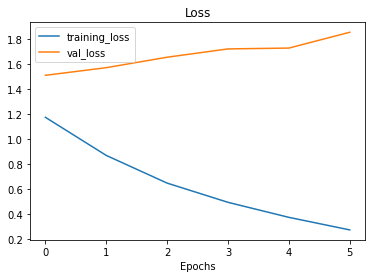

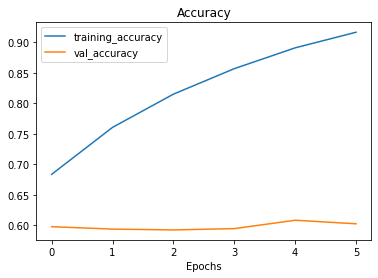

In [23]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

In [25]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 82s 103ms/step - loss: 1.7608 - accuracy: 0.6164


[1.760830283164978, 0.6164356470108032]

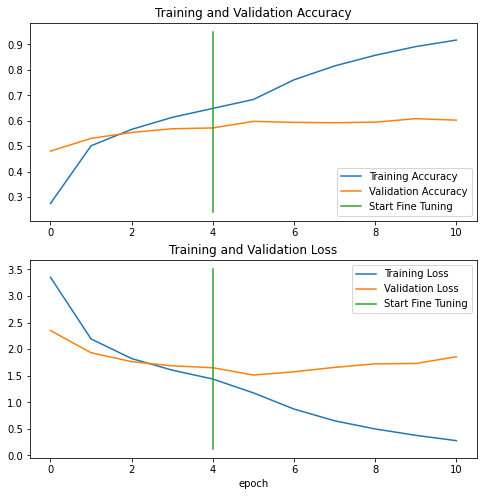

In [28]:
## Compare the history of feature extraction vs fine tuned
from Helper import compare_historys
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## saving and loading our model

### To use our model in external application, we will need to save it and export it somewhere.

In [29]:
## save our fine-tuning model
model.save("101_food_classes_10_percent_big_dog_model")

In [32]:
## Loading the model
loaded_model = tf.keras.models.load_model("101_food_classes_10_percent_big_dog_model")
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_augmentataiton_layer (  (None, 224, 224, 3)      0         
 Sequential)                                                     
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [34]:
## Evaludate loaded model and compare performance to presaved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results



790/790 [==============================] - 83s 104ms/step - loss: 1.7608 - accuracy: 0.6164


[1.7608304023742676, 0.6164356470108032]

In [35]:
all_classes_10_percent_fine_tune_results

[1.760830283164978, 0.6164356470108032]

In [38]:
import numpy as np
np.round(all_classes_10_percent_fine_tune_results,2) == np.round(loaded_model_results,2)

array([ True,  True])